## <font color = '#6495ED'>  ________________ **Reinforcement Learning - Lunar Lander** _________________
#### _______________________________________________Academic Year: 2024/2025 _____________________________________________

<div style="text-align: center;">
    <strong>Group Members</strong>
    <table style="margin: 0 auto; border-collapse: collapse; border: 1px solid black;">
        <tr>
            <th style="border: 1px solid white; padding: 8px;">Name</th>
            <th style="border: 1px solid white; padding: 8px;">Student ID</th>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Afonso Ascenção</td>
            <td style="border: 1px solid white; padding: 8px;">20240684</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Afonso Silva</td>
            <td style="border: 1px solid white; padding: 8px;">20240495</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Elcano Gaspar</td>
            <td style="border: 1px solid white; padding: 8px;">20241021</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Osmáiny Leontina</td>
            <td style="border: 1px solid white; padding: 8px;">20191506</td>
        </tr>
    </table>
</div>

### <font color = '#6495ED'>**Project Description**</font>

#### *Objective:*
The goal of this project is to develop and evaluate two Reinforcement Learning (RL) agents capable of solving two distinct environments from the Gymnasium library. The project aims to explore the design and implementation of RL algorithms in environments with diverse state and action spaces.

#### *Environments:*
We choose two different environments from the Gymnasium library that were not covered in class. At least one environment must have a non-discrete/non-tabular observation space (e.g., continuous or mixed).

#### *Methodology:*
The project follow these steps:

- Environment Selection: Choose two distinct Gymnasium environments, with at least one having a non-discrete observation space.
- Algorithm Implementation: Implement two different RL algorithms (SARSA and PPO) for each chosen environment.
- Agent Training: Train the developed RL agents in their respective environments.
- Evaluation and Analysis: Record and analyze performance metrics such as total reward per episode/return, convergence speed, and the balance between exploration and exploitation.
- Visualization: Provide visualizations of learning progress, including reward curves and success rates.
- Comparative Analysis: Perform a comparative analysis of the chosen algorithms and environments.
- Behavior Interpretation: Interpret and explain the agent's behavior in each environment, analyzing its actions and learning patterns.

#### *Success Metrics:*
Our primary success metrics will include:

Total Reward per Episode/Return: To measure the overall performance of the agent.
Convergence Speed: To evaluate how quickly the agent learns an effective policy.
Exploration vs. Exploitation Balance: To understand the agent's strategy for discovering and leveraging rewards.
Visualizations: Clarity and interpretability of plots representing learning and performance.

Argumentation of Methods: Understanding how different learning methods work, their relevance, and usefulness in solving the problem and how can they be enhanced in the future, will be the focus of the evaluation.

#### *Variable description:*
| **ATTRIBUTE** | **DESCRIPTION**                                                                                   |
|---------------|---------------------------------------------------------------------------------------------------|
| State         | The current observation of the environment, used by the agent to make decisions.                                 |
| Action        | The decision made by the agent at a given state, which affects the environment.                                       |
| Label         | A scalar feedback signal from the environment indicating the immediate success or failure of an action, used to guide agent learning        |

### <font color = '#6495ED'>  **1. Libraries, Environment, Configuration** </font>

#### <font color = '#6495ED'> **1.1. Import the Needed Libraries** </font>

In [99]:
#!pip install gymnasium[box2d]
#!pip install swig
#!pip install gymnasium[other]

In [100]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import time
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.vec_env import VecVideoRecorder
from IPython.display import Video
import os

#### <font color = '#6495ED'> **1.2. Environment - Lunar Lander Continuous-V3** </font>

This environment is part of the Box2D environments. This continuous control task requires a lander to touch down softly at the center of a landing pad using two engine thrusters.

- **State space**: 8D vector [position, velocity, angle, angular velocity, left/right leg contact]
- **Action space**: 2D continuous vector (main engine, side engine)
- **Goal**: Land without crashing
- **Reward**: Based on proximity to landing zone, velocity, angle, leg contact, and fuel use

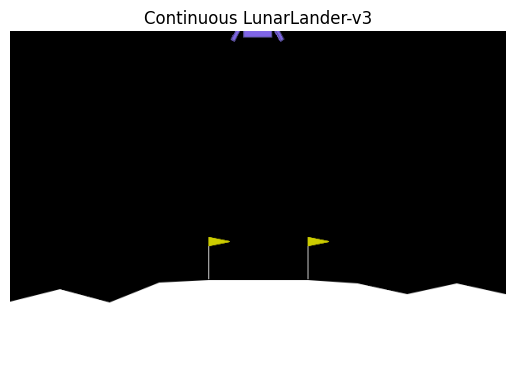

Observation space shape: (8,)
Action space shape: (2,)
Action range: [-1. -1.] to [1. 1.]
Sample observation: [-0.00264311  1.4204781  -0.26773074  0.42480204]...


In [101]:
def make_env(env_name, seed=None, render_mode=None, **kwargs):
    env = gym.make(env_name, render_mode=render_mode, **kwargs)
    env = Monitor(env)
    if seed is not None:
        env.reset(seed=seed)
        env.action_space.seed(seed)
    return env

# Create and inspect CONTINUOUS environment
env_name = 'LunarLanderContinuous-v3'

env = make_env(
    env_name,
    render_mode='rgb_array',
    continuous=True,  # Must be True for v3
    gravity=-10.0
)
obs, info = env.reset()

# Render initial state
plt.imshow(env.render())
plt.axis('off')
plt.title("Continuous LunarLander-v3")
plt.show()

# Continuous-specific inspection
print(f"Observation space shape: {env.observation_space.shape}")  # 8 values
print(f"Action space shape: {env.action_space.shape}")  # [2] for continuous
print(f"Action range: {env.action_space.low} to {env.action_space.high}")  # [-1,-1] to [1,1]
print(f"Sample observation: {obs[:4]}...")

env.close()

In [102]:
vec_env = make_vec_env(env_name, n_envs=1)
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True, clip_obs=10.)

# Setup evaluation environment with SAME normalization
eval_env = make_vec_env(env_name, n_envs=1)
eval_env = VecNormalize(eval_env, training=False, norm_obs=True, norm_reward=True, clip_obs=10.)

# Sync normalization stats from training environment
eval_env.obs_rms = vec_env.obs_rms

### Build Actor Critic Network

We will build two simple networks that take in state. One network produces parameters for a continuous distribution (for continuous action spaces). The second network produces the Value of the state. The observation space and action space for LunarLander are given below for both its discrete and continuous action versions.

    Observation:
        Type: Box(8) - continuous
        Num     Observation               Min                             Max
        0       Lander X Position         -1.5                            1.5
        1       Lander Y Position         -1.5                            1.5
        2       Lander X Velocity         -5.0                            5.0
        3       Lander Y Velocity         -5.0                            5.0
        4       Lander Angle              -3.14 rad (approx -180 deg)     3.14 rad (approx -180 deg)
        5       Lander Angular Velocity   -5.0                            5.0
        6       Left Leg Contact           0                              1
        7       Right Leg Contact          0                              1
    Actions:
        Type: Continuous (2)
        Num     Action                    Min                             Max
        0:      Main Engine Throttle     -1.0                             1.0
        1:      Side Engines Throttle    -1.0                             1.0

Continuous Actions: For the main engine, values < 0 turn it off; values from 0 to 1 scale throttle from 50% to 100%. For side engines, values between -0.5 and 0.5 do nothing; values from -1.0 to -0.5 fire the left booster (50% to 100% throttle); values from 0.5 to 1.0 fire the right booster (50% to 100% throttle).

### <font color = '#6495ED'>  **2. Model** </font>

In [103]:
## Custom Callback for Reward Logging

class RewardCallback(BaseCallback):
    def __init__(self, eval_env, eval_freq=10_000):
        super().__init__()
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.episode_rewards = []
        self.episode_lengths = []
        self.eval_rewards = []
        self.entropy_vals = []

    def _on_step(self) -> bool:
        if self.locals.get("dones") is not None and any(self.locals["dones"]):
            infos = self.locals["infos"]
            for info in infos:
                if "episode" in info:
                    self.episode_rewards.append(info["episode"]["r"])
                    self.episode_lengths.append(info["episode"]["l"])

        if self.n_calls % self.eval_freq == 0:
            mean_reward, _ = evaluate_policy(self.model, self.eval_env, n_eval_episodes=5)
            self.eval_rewards.append(mean_reward)
            self.entropy_vals.append(float(self.model.logger.name_to_value.get("train/entropy_loss", 0)))
        return True

In [104]:
##  PPO Model Initialization
policy_kwargs = dict(net_arch=dict(pi=[256, 256], vf=[256, 256]))

model = PPO(
    "MlpPolicy",
    vec_env,
    policy_kwargs=policy_kwargs,
    verbose=1,
    learning_rate=3e-4,
    n_steps=4096,
    batch_size=128,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    device='cpu'
)

Using cpu device


#### <font color = '#6495ED'> **2.1. Train the PPO Agent** </font>

In [7]:
reward_callback = RewardCallback(eval_env=eval_env, eval_freq=10_000)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./logs/",
    log_path="./logs/",
    eval_freq=10_000,
    deterministic=True,
    render=False
)

start_time = time.time()
model.learn(total_timesteps=1_000_000, callback=[reward_callback, eval_callback])
elapsed_time = time.time() - start_time
print(f"\n Training complete in {elapsed_time:.2f} seconds")

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 112      |
|    ep_rew_mean     | -232     |
| time/              |          |
|    fps             | 1418     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 4096     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 124        |
|    ep_rew_mean          | -221       |
| time/                   |            |
|    fps                  | 903        |
|    iterations           | 2          |
|    time_elapsed         | 9          |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.00759996 |
|    clip_fraction        | 0.0735     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.83      |
|    explained_variance   | 0.0136     |
|    learning_rate        | 0.0003     |
|   

In [8]:
model.save("ppo_mlp_lunarlander_continuous")

#### <font color = '#6495ED'> **2.2. Evaluate the PPO Agent** </font>

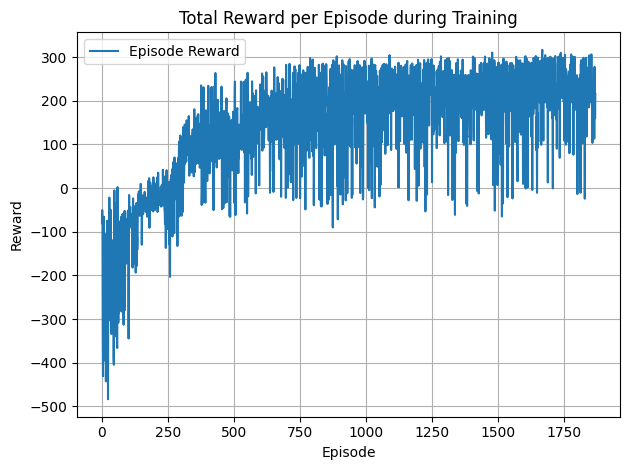

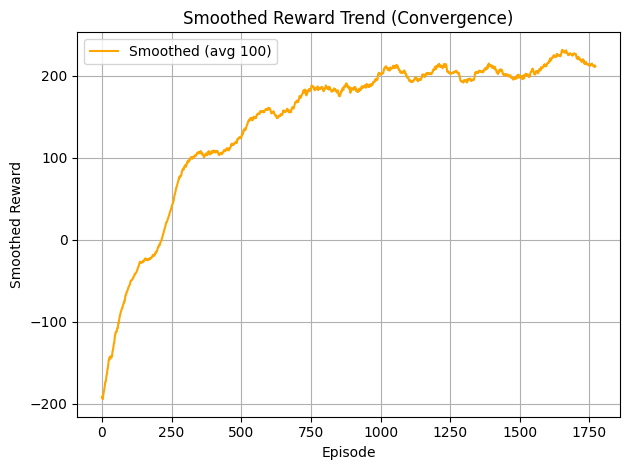

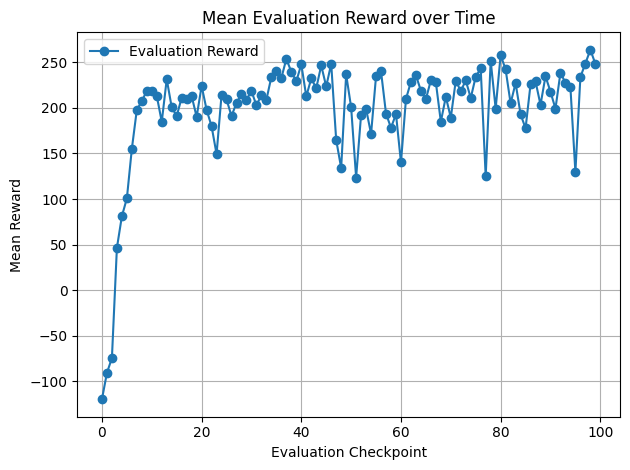

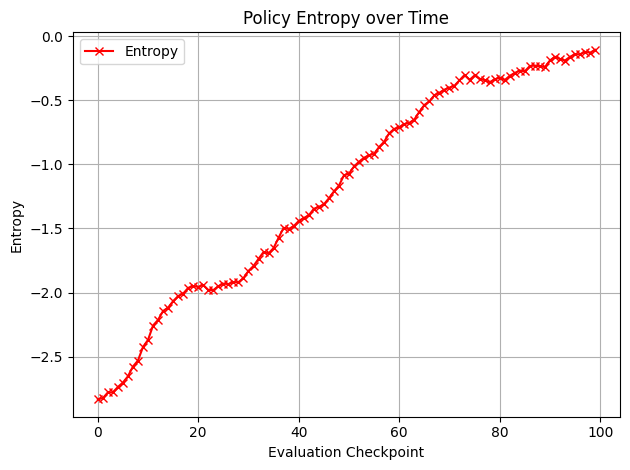

In [105]:
plt.plot(reward_callback.episode_rewards, label="Episode Reward")
plt.title("Total Reward per Episode during Training")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

window = 100
smoothed = np.convolve(reward_callback.episode_rewards, np.ones(window)/window, mode='valid')
plt.plot(smoothed, label=f"Smoothed (avg {window})", color="orange")
plt.title("Smoothed Reward Trend (Convergence)")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(reward_callback.eval_rewards, label="Evaluation Reward", marker='o')
plt.title("Mean Evaluation Reward over Time")
plt.xlabel("Evaluation Checkpoint")
plt.ylabel("Mean Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(reward_callback.entropy_vals, label="Entropy", color='red', marker='x')
plt.title("Policy Entropy over Time")
plt.xlabel("Evaluation Checkpoint")
plt.ylabel("Entropy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [106]:
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=100, render=False)
print(f"\n Mean reward over 100 episodes: {mean_reward:.2f} +/- {std_reward:.2f}")


 Mean reward over 100 episodes: -205.42 +/- 101.12


### <font color = '#6495ED'>  **3. Agent Video** </font>

In [107]:
model = PPO.load("ppo_mlp_lunarlander_continuous", env=vec_env)

In [116]:
# Create the environment with 'human' render mode
env = gym.make(env_name, render_mode="human")
obs, info = env.reset()
done = False

while not done:
    action, _ = model.predict(obs, deterministic=False)
    obs, reward, done, truncated, info = env.step(action)
    time.sleep(0.03)
    if truncated:
        break

env.close()

In [14]:
video_dir = "./ppo_lander_video/"
os.makedirs(video_dir, exist_ok=True)

# Create a new vectorized environment for video recording,
# and apply the same normalization as the training environment.
# It's important that this environment is *not* for training (`training=False`)
# and uses the same observation normalization statistics (`obs_rms`).
video_record_env = make_vec_env(env_name, n_envs=1, wrapper_class=Monitor)
video_record_env = VecNormalize(video_record_env, training=False, norm_obs=True, norm_reward=True, clip_obs=10.)
video_record_env.obs_rms = vec_env.obs_rms # Crucial for consistent normalization

video_env = VecVideoRecorder(
    video_record_env, # Use the properly normalized environment
    video_folder=video_dir,
    record_video_trigger=lambda x: x == 0, # Records at the beginning of training
    video_length=1000, # Adjust as needed for one episode
    name_prefix="ppo_lander"
)

model.set_env(video_env)
# Learn for a very small number of timesteps to trigger the video recording at step 0
# This is a common pattern to record an initial episode.
model.learn(total_timesteps=1) # Only run for 1 timestep to trigger video on reset
video_env.close()

print(" Video recorded. To preview in Colab or Jupyter, run below:")
# The file name will be ppo_lander-step-0-to-step-X.mp4 where X is the video_length
# You might need to adjust the path if video_length is very long
Video(f"{video_dir}/ppo_lander-step-0-to-step-{video_env.video_length}.mp4", embed=True)

Saving video to C:\Users\afons\PycharmProjects\RL1\project\ppo_lander_video\ppo_lander-step-0-to-step-1000.mp4
MoviePy - Building video C:\Users\afons\PycharmProjects\RL1\project\ppo_lander_video\ppo_lander-step-0-to-step-1000.mp4.
MoviePy - Writing video C:\Users\afons\PycharmProjects\RL1\project\ppo_lander_video\ppo_lander-step-0-to-step-1000.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\afons\PycharmProjects\RL1\project\ppo_lander_video\ppo_lander-step-0-to-step-1000.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 609      |
|    ep_rew_mean     | 135      |
| time/              |          |
|    fps             | 322      |
|    iterations      | 1        |
|    time_elapsed    | 12       |
|    total_timesteps | 4096     |
---------------------------------
 Video recorded. To preview in Colab or Jupyter, run below:


===================================================================================================